In [143]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from scipy import special
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from itertools import combinations as combs
from statsmodels.tsa.arima.model import ARIMA

In [55]:
xl_file = pd.ExcelFile('Data/ZooPlanktonPerryData.xlsx')

Original_Salmon_Sheets = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

#The Zooplankton anomalies represent the difference of plankton biomass in a given year from the mean value of biomass over a set of years.
anom = Original_Salmon_Sheets['3. Zooplankton anomalies']
anom = anom[6:]
viab = Original_Salmon_Sheets['5. Salmon marine survivals']
zoos = anom[anom.columns[3:]]

In [35]:
#Fitting a Dynamic Factor Analysis Model. This assumes that our Zoo Plankton Anomalies are determined by a few, uncorrelated "latent factors". 
model = sm.DynamicFactorMQ(endog=anom, factors=4, factor_orders=1,
                           idiosyncratic_ar1=True)
results = model.fit(maxiter=500)
preds = results.predict(start = 0, end = 22)

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1870: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.DataFrame(self.endog).interpolate().fillna(method='backfill'),


In [135]:
#We also attempt the sklearn approach. I don't really understand what is going on here but it seems like some kind of dimensionality reduction...
X = StandardScaler().fit_transform(anom)
feature_names = anom.columns
n_comps = 9
fa = FactorAnalysis(rotation="varimax")

fa.set_params(n_components=n_comps)
fa.fit(X.T)
newExpVars = fa.components_.T
np.mean(fa.score_samples(X.T))


#methods = [
#    ("PCA", PCA()),
#    ("Unrotated FA", FactorAnalysis()),
#    ("Varimax FA", FactorAnalysis(rotation="varimax")),
#]
#fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 8), sharey=True)

#for ax, (method, fa) in zip(axes, methods):
#
#
#    components = fa.components_.T
#    print("\n\n %s :\n" % method)
#    print(components)
#
#    vmax = np.abs(components).max()
#    ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
#    ax.set_yticks(np.arange(len(feature_names)))
#    ax.set_yticklabels(feature_names)
#    ax.set_title(str(method))
#    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#fig.suptitle("Factors")
#plt.tight_layout()
#plt.show()

-15.968855575992796

In [16]:
#Compute the logit's of the Viability data and then standardize
logitViab = special.logit(viab[["Cowichan Chinook",	"Harrison Chinook",	"Puntledge Chinook",	"Big Qualicum Coho"]])
logitViab["Ocean Entry Year"] = viab["Ocean Entry Year"]
means = np.nanmean(logitViab[["Cowichan Chinook",	"Harrison Chinook",	"Puntledge Chinook",	"Big Qualicum Coho"]], axis = 0)
stds = np.nanstd(logitViab[["Cowichan Chinook",	"Harrison Chinook",	"Puntledge Chinook",	"Big Qualicum Coho"]], axis = 0)
stdViab = (logitViab[["Cowichan Chinook",	"Harrison Chinook",	"Puntledge Chinook",	"Big Qualicum Coho"]] - means)/stds
stdViab["Ocean Entry Year"] = viab["Ocean Entry Year"]


In [ ]:
test_size = 5
CC  = stdViab["Cowichan Chinook"]
CC.iloc[15] = (CC.iloc[14] + CC.iloc[16])/2
LR = LinearRegression()
LR.fit(fa.components_.T[:-test_size], CC[6:-test_size])
#plt.plot(stdViab["Ocean Entry Year"], CC)
#plt.plot(stdViab["Ocean Entry Year"][6:-test_size], LR.predict(fa.components_.T[:-test_size]))
#plt.plot(stdViab["Ocean Entry Year"][-test_size - 1:-1], LR.predict(fa.components_.T[-test_size - 1:-1]))

In [127]:
CC[6:-1]

6    -0.339252
7    -0.417319
8    -0.052283
9     0.156641
10   -0.253237
11   -1.157812
12   -0.886236
13   -1.596185
14   -1.168694
15   -1.181656
16   -1.194618
17   -1.515755
18   -0.673404
19   -0.294018
20    0.436909
21    0.703431
22    0.486788
23   -0.383216
24   -0.832191
25    0.129500
26    0.020498
27    0.892479
Name: Cowichan Chinook, dtype: float64

In [136]:
newExpFrame = pd.DataFrame(newExpVars)

In [144]:
#Get a list of possible subsets of size at most params from newExpFrame.columns
subsets = list(combs(newExpFrame.columns, 5))
mses = np.zeros(len(list(subsets)))
#For each list in subsets fit a model and compute the mse
i = 0
for sub in subsets:
    X = newExpFrame[list(sub)]
    LR.fit(X[:-1], CC[6:-1])
    mses[i] = mse(LR.predict(X[:-1]), CC[6:-1])
    if(i%1000 == 0):
        print(i)
    i = i + 1
best = list(subsets[np.argmin(mses)])
 

0


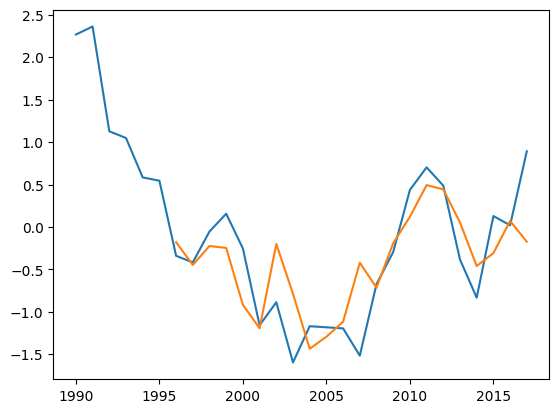

In [150]:
test_size = 1
LR.fit(newExpFrame[best][:-test_size], CC[6:-test_size])
plt.plot(stdViab["Ocean Entry Year"], CC)
plt.plot(stdViab["Ocean Entry Year"][6:-test_size], LR.predict(newExpFrame[best][:-test_size]))
plt.plot(stdViab["Ocean Entry Year"][-test_size - 1:-1], LR.predict(newExpFrame[best][-test_size - 1:-1]))

/tmp/ipykernel_3322/680267086.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CC.iloc[15] = (CC.iloc[14] + CC.iloc[16])/2


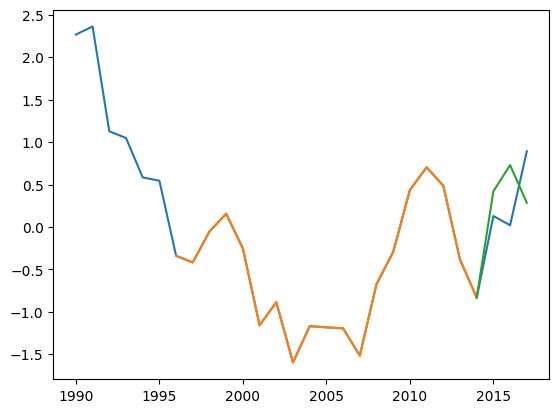

In [59]:
#LR.fit(anom[anom.columns[3:]][:-test_size], CC[6:-test_size])
#plt.plot(stdViab["Ocean Entry Year"], CC)
#plt.plot(stdViab["Ocean Entry Year"][6:-test_size], LR.predict(zoos[:-test_size]))
#plt.plot(stdViab["Ocean Entry Year"][-test_size - 1:-1], LR.predict(zoos[-test_size - 1:-1]))